In [4]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [74]:
# Lower level imports
from algo.prox import prox_G,prox_F1_dual,prox_F2_dual
from algo.pdhg import pdhg
from algo.cost_utils import *

#Upper level imports
from scipy.sparse.linalg import cg,LinearOperator
import scipy

In [6]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data

n=512
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

y = (1+0j)*fourier_op.op(np.real(u0_mat))+1e-6*np.random.randn(2*n*n).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [7]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
p = np.zeros((n*n+1,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1
p[-1]=1e-6

#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=4,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

# Definition of functions
Only for one linear operator for the moment (wavelet).

In [8]:
param = {"zeta":1e15,"pn1":p[-1],"epsilon":1e-5,"gamma":1e-10}

#Definition of phi=rho'(x)/x and psi=phi'(x)/x
def rho(x):
    if x<-param["gamma"]:return -x-param["gamma"]/3
    elif x<0:return x**3/3/param["gamma"]**2+x**2/param["gamma"]
    elif x<param["gamma"]:return -x**3/param["gamma"]**2/3+x**2/param["gamma"]
    else:return x-param["gamma"]/3
    
def phi(x):
    if x<-param["gamma"]:return -1/x
    elif x<0:return x/param["gamma"]**2+2/param["gamma"]
    elif x<param["gamma"]:return -x/param["gamma"]**2+2/param["gamma"]
    else:return 1/x

def psi(x):
    x=abs(x)
    if x<param["gamma"]:return -1/param["gamma"]**2/x
    else:return -1/x**3


def rho_vec(x):
    x = np.abs(x)
    return np.where(x<param["gamma"],-x**3/3/param["gamma"]**2+x**2/param["gamma"],x-param["gamma"]/3)

def phi_vec(x):
    x = np.abs(x)
    return np.where(x<=param["gamma"],-x/param["gamma"]**2+2/param["gamma"],1/x)

def psi_vec(x):
    x = np.abs(x)
    return np.where(x<param["gamma"],-1/x/param["gamma"]**2,-1/x**3)

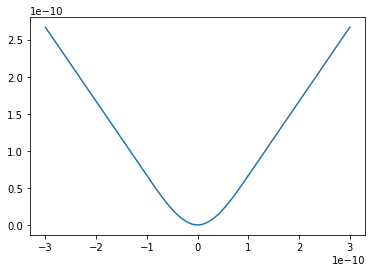

In [9]:
x = np.linspace(-3*param["gamma"],3*param["gamma"],200)
plt.plot(x,rho_vec(x))

# Functions and first order derivatives

In [10]:
from algo.cost_utils import b
#Base functions
Eeps = lambda x:param["epsilon"]/2*np.linalg.norm(x)**2
Edata = lambda x:f1(x,p[:-1],y,fourier_op)
Enonneg = lambda x:b(x,param["zeta"])
Ereg = lambda x:param["pn1"]*np.sum(rho_vec(linear_op.op(x)))
Etot = lambda x:Eeps(x)+Edata(x)+Enonneg(x)+Ereg(x)

#First order derivatives
Du_Eeps = lambda x:param["epsilon"]*x
Du_Edata = lambda x:np.real(fourier_op.adj_op(p[:-1]**2*(fourier_op.op(Rstar(x))-y)))
Du_Enonneg = lambda x:-3*param["zeta"]*np.where(x<=0,x**2,0)
Du_Ereg = lambda x:param["pn1"]*linear_op.adj_op(phi_vec(linear_op.op(x))*linear_op.op(x))
Du_Etot = lambda x:Du_Eeps(x)+Du_Edata(x)+Du_Enonneg(x)+Du_Ereg(x)

### Numerical check
Plots of $\left|\frac{f(a+th)-f(a)-<\nabla f(a),th>}{tf(a)}\right|$ for $t\rightarrow 0$. Eeps, Edata and Enonneg seem to work, but problem with Ereg.

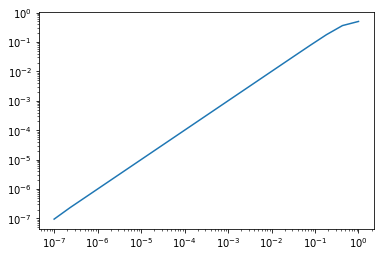

In [205]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(512*512).reshape((512,512))
a2 = np.random.randn(512*512).reshape((512,512))

tests = np.logspace(-7,0,20)
real_values = np.array([Eeps(a+t*a2) for t in tests])
approx = np.array([Eeps(a)+t*np.sum(Du_Eeps(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")
plt.yscale("log")

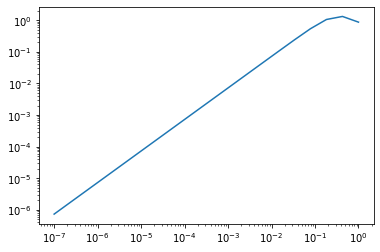

In [206]:
# -- Edata --
#Random vector with same amplitude as u0
a2 = np.random.randn(512*512).reshape((512,512))/512*np.linalg.norm(u0_mat)


tests = np.logspace(-7,0,20)
real_values = np.array([Edata(u0_mat+t*a2) for t in tests])
approx = np.array([Edata(u0_mat)+t*np.sum(Du_Edata(u0_mat)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")
plt.yscale("log")

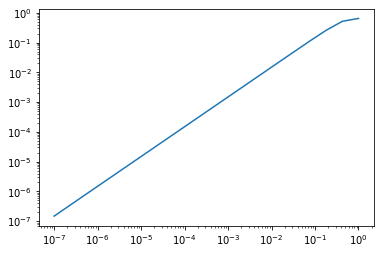

In [207]:
# -- Enonneg --
#Two random vectors with same amplitude
a = np.random.randn(512*512).reshape((512,512))
a2 = np.random.randn(512*512).reshape((512,512))

tests = np.logspace(-7,0,20)
real_values = np.array([Enonneg(a+t*a2) for t in tests])
approx = np.array([Enonneg(a)+t*np.sum(Du_Enonneg(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")
plt.yscale("log")

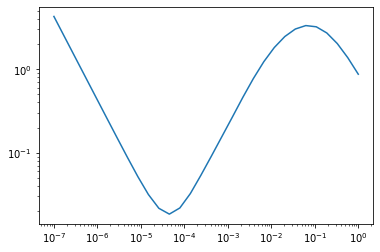

In [219]:
# -- Ereg --
#Random vector with same amplitude as u0
a2 = np.random.randn(512*512).reshape((512,512))/512*np.linalg.norm(u0_mat)

tests = np.logspace(-7,-0,30)
real_values = np.array([Ereg(u0_mat+t*a2) for t in tests])
approx = np.array([Ereg(u0_mat)+t*np.sum(Du_Ereg(u0_mat)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")
plt.yscale("log")

Gap between limits:4.7254233456781e-14


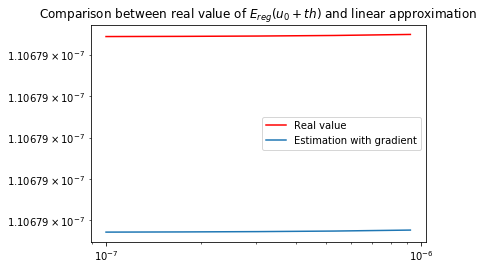

In [220]:
print(f"Gap between limits:{real_values[0]-approx[0]}")

plt.plot(tests[:5],real_values[:5],'r',label="Real value")
plt.plot(tests[:5],approx[:5],label="Estimation with gradient")
plt.xscale("log")
plt.yscale("log")
plt.title("Comparison between real value of $E_{reg}(u_0+th)$ and linear approximation")
plt.legend()

Always the same gap, whatever a2 (4.7254e-14) when we use u0. If we use a random a instead of u0, seems to work.

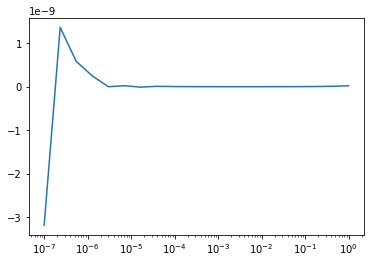

In [226]:
# -- Etot --
#Random vector with same amplitude as u0
a2 = np.random.randn(512*512).reshape((512,512))/512*np.linalg.norm(u0_mat)

tests = np.logspace(-7,0,20)
real_values = np.array([Etot(a+t*a2) for t in tests])
approx = np.array([Etot(a)+t*np.sum(Du_Etot(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")

# Second order derivatives
We don't express the hessians as matrices but as linear operators. Same verifications: $\frac{||\nabla f(a+th)-(\nabla f(a)+t\nabla^2f(a)h)||_2}{||\nabla f(a)||_2}$.

In [17]:
def Du2_Eeps(u,p,w):return param["epsilon"]*w
def Du2_Edata(u,p,w):return np.real(fourier_op.adj_op(p[:-1]**2*fourier_op.op(w)))
def Du2_Enonneg(u,p,w):return -6*param["zeta"]*np.where(u<0,u,0)*w
def Du2_Ereg(u,p,w):
    lin_u = linear_op.op(u)
    lin_w = linear_op.op(w)
    psi_Au = psi_vec(lin_u)
    return linear_op.adj_op(lin_u**2*lin_w*psi_Au)
def Du2_Etot(u,p,w):return Du2_Eeps(u,p,w)+Du2_Edata(u,p,w)+Du2_Enonneg(u,p,w)+Du2_Ereg(u,p,w)

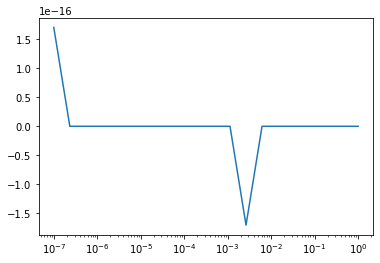

In [223]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(512*512).reshape((512,512))
a2 = np.random.randn(512*512).reshape((512,512))

tests = np.logspace(-7,0,20)
real_values = np.array([np.linalg.norm(Du_Eeps(a+t*a2)) for t in tests])
approx = np.array([np.linalg.norm(Du_Eeps(a)+Du2_Eeps(a,p,t*a2)) for t in tests])

plt.plot(tests,(real_values-approx)/real_values)
#plt.plot(tests,vals2,'r')
plt.xscale("log")

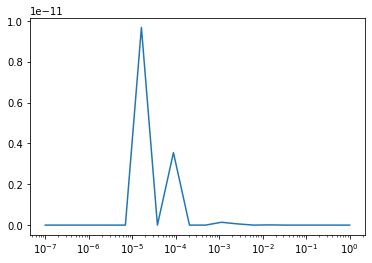

In [233]:
# -- Edata --
#Random vector with same amplitude as u0
a2 = np.random.randn(512*512).reshape((512,512))/512*np.linalg.norm(u0_mat)

tests = np.logspace(-7,0,20)
real_values = np.array([np.linalg.norm(Du_Edata(u0_mat+t*a2)) for t in tests])
approx = np.array([np.linalg.norm(Du_Edata(u0_mat)+Du2_Edata(u0_mat,p,t*a2)) for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")

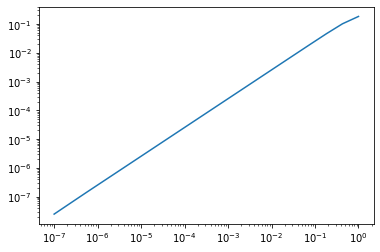

In [232]:
# -- nonneg --
#Two random vectors with same amplitude
a = np.random.randn(512*512).reshape((512,512))-0.5
a2 = np.random.randn(512*512).reshape((512,512))

tests = np.logspace(-7,0,20)
real_values = np.array([np.linalg.norm(Du_Enonneg(a+t*a2)) for t in tests])
approx = np.array([np.linalg.norm(Du_Enonneg(a)+Du2_Enonneg(a,p,t*a2)) for t in tests])

plt.plot(tests,(real_values-approx)/real_values/tests)
plt.xscale("log")
plt.yscale("log")

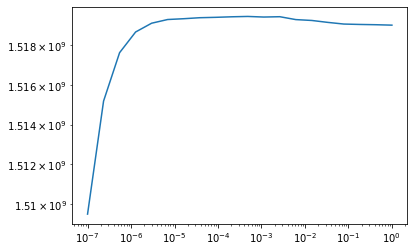

In [240]:
# -- Ereg --
#Random vector with same amplitude as u0
a2 = np.random.randn(512*512).reshape((512,512))/512*np.linalg.norm(u0_mat)

tests = np.logspace(-7,0,20)
real_values = np.array([np.linalg.norm(Du_Ereg(u0_mat+t*a2)) for t in tests])
approx = np.array([np.linalg.norm(Du_Ereg(u0_mat)+Du2_Ereg(u0_mat,p,t*a2)) for t in tests])

plt.plot(tests,abs((real_values-approx)/real_values/tests))
plt.xscale("log")
plt.yscale("log")

In [18]:
def Dpu_Edata(u,p,w):
    Fu = np.conj(fourier_op.op(Rstar(u))-y)
    Fw = fourier_op.op(w)
    return 2*np.real(p[:-1]*Fu*Fw)
def Dpu_Ereg(u,p,w):
    return np.sum(w*linear_op.adj_op(phi_vec(linear_op.op(u))*linear_op.op(u)))

def Dpu_Etot(u,p,w):
    g = np.zeros((512*512+1,))
    g[:-1] = Dpu_Edata(u,p,w)
    g[-1] = Dpu_Ereg(u,p,w)
    return g

## Loss function and penalty

In [143]:
def L(u,u2):return np.linalg.norm(u-u2)**2
def grad_L(u,u2):return 2*(u-u2)

beta = 1e-10
def P(p):return beta*np.sum(p[:-1]*(1-p[:-1]))
def grad_P(p):
    Dp = 1-2*p
    #Don't change alpha
    Dp[-1] = 0
    return beta*Dp

# Upper level energy

In [241]:
uk = np.zeros(u0_mat.shape)

def E(pk):
    global uk
    print("\nEvaluating E(p)")
    param["pn1"]=pk[-1]
    uk,norms,energy = pdhg(y,pk[:-1],fourier_op,linear_op,param,maxit=20,verbose=0)
    return L(uk,u0_mat)+P(pk)

def grad_E(pk):
    global uk
    #Update alpha(p)
    param["pn1"]=pk[-1]
    
    print("\nStarting PDHG")
    uk,norms,energy = pdhg(y,pk[:-1],fourier_op,linear_op,param,maxit=20,verbose=0)
    
    def mv(w):
        w = np.reshape(w,(512,512))
        return np.reshape(Du2_Etot(uk,pk,w),(512*512,))
    
    # -- Use cg to compute gradient --
    lin = LinearOperator((512*512,512*512),matvec=mv)
    B = np.reshape(grad_L(uk,u0_mat),(512*512,))
    
    print("\nStarting Conjugate Gradient method")
    x_inter,convergence = cg(lin,B,tol=1e-4,maxiter=50)
    return Dpu_Etot(uk,pk,np.reshape(x_inter,(512,512)))+grad_P(pk)

niter = 0
def fcall(x):
    global uk,niter
    niter += 1
    print(f"\n{niter} iterations: ssim={ssim(uk,u0_mat)}\n\n")

In [255]:
p0 = np.random.rand(512*512+1)
Ep0,gradEp0 = E(p0),grad_E(p0)
p1 = np.random.rand(512*512+1)

tests = np.logspace(-7,0,20)
real_values = np.array([E(p0+t*p1) for t in tests])
approx = np.array([Ep0+t*np.sum(gradEp0*p1) for t in tests])


Evaluating E(p)
Finished in 9.509022951126099 seconds.

Starting PDHG
Finished in 9.511437177658081 seconds.

Starting Conjugate Gradient method

Evaluating E(p)
Finished in 9.563354253768921 seconds.

Evaluating E(p)
Finished in 9.571742534637451 seconds.

Evaluating E(p)
Finished in 9.512110948562622 seconds.

Evaluating E(p)
Finished in 9.513763189315796 seconds.

Evaluating E(p)
Finished in 9.628834247589111 seconds.

Evaluating E(p)
Finished in 9.510279417037964 seconds.

Evaluating E(p)
Finished in 9.546612024307251 seconds.

Evaluating E(p)
Finished in 9.511719942092896 seconds.

Evaluating E(p)
Finished in 9.488060712814331 seconds.

Evaluating E(p)
Finished in 9.50137186050415 seconds.

Evaluating E(p)
Finished in 9.501596927642822 seconds.

Evaluating E(p)
Finished in 9.486013174057007 seconds.

Evaluating E(p)
Finished in 9.777441501617432 seconds.

Evaluating E(p)
Finished in 10.108941793441772 seconds.

Evaluating E(p)
Finished in 9.823137760162354 seconds.

Evaluating E(

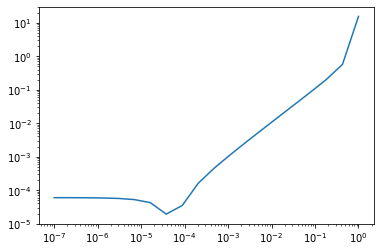

In [256]:
plt.plot(tests,abs((real_values-approx)/real_values/tests))
plt.xscale("log")
plt.yscale("log")

# L-BFGS-B

In [245]:
p0 = np.random.rand(512*512+1)
p0[-1] = 1e-7
res = scipy.optimize.minimize(E,p,method='L-BFGS-B',jac=grad_E
                              ,bounds=[(0,1)]*512*512+[(0,np.inf)]
                              ,callback=fcall
                              ,options={'ftol':1e-30,'maxiter':3,'maxfun':3})


Evaluating E(p)
Finished in 10.285285949707031 seconds.

Starting PDHG
Finished in 10.563462257385254 seconds.

Starting Conjugate Gradient method


In [246]:
pf = res.x
print(E(p),E(pf))


Evaluating E(p)
Finished in 10.541069507598877 seconds.

Evaluating E(p)
Finished in 10.288304090499878 seconds.
8.31825176857e-08 3.53271254514e-07


In [249]:
print(pf[-1])
pysap.Image(data=np.reshape(pf[:-1],(512,512))).show()

9e-07


10  iterations:
Cost: 1.50831813763e-07 
Norm: 0.0776682254923 

20  iterations:
Cost: 1.46064127054e-07 
Norm: 0.00653630178647 

30  iterations:
Cost: 1.45449826117e-07 
Norm: 0.0017374670183 

40  iterations:
Cost: 1.45357723244e-07 
Norm: 0.000939767465303 

50  iterations:
Cost: 1.45326445854e-07 
Norm: 0.00067869197258 

60  iterations:
Cost: 1.45310355407e-07 
Norm: 0.000544556572825 

70  iterations:
Cost: 1.45299458079e-07 
Norm: 0.00044207657829 

80  iterations:
Cost: 1.45291710052e-07 
Norm: 0.000378156681427 

90  iterations:
Cost: 1.45286324637e-07 
Norm: 0.000325014071773 

100  iterations:
Cost: 1.45281516077e-07 
Norm: 0.000282938086491 

Finished in 54.95491170883179 seconds.
0.892542837098


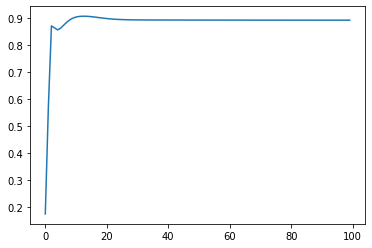

In [101]:
uk,norms,energy,ssims = pdhg(y,pf[:-1],fourier_op,linear_op,param,real_image=u0_mat,maxit=100)
print(ssim(uk,u0_mat))
plt.plot(ssims)
pysap.Image(data=uk).show()